In [1]:
## Import things

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import networkX
import networkx as nx

# Import multiNetX
import multinetx as mx

# Need to save as json
import scipy.io as sio
from networkx.readwrite import json_graph
import json
import pandas as pd

print("Done importing packages :)")

Done importing packages :)


## Multilayer network ex 1: Two aspects, two layers

Aspect L1: nodes as usual
Aspect L2: "A" or "B"

In [3]:
nNodes = 17

g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)

# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*3,nNodes*3)))
adj_block[0:  nNodes,  nNodes:2*nNodes] = np.identity(nNodes)    # L_12
adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2],
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


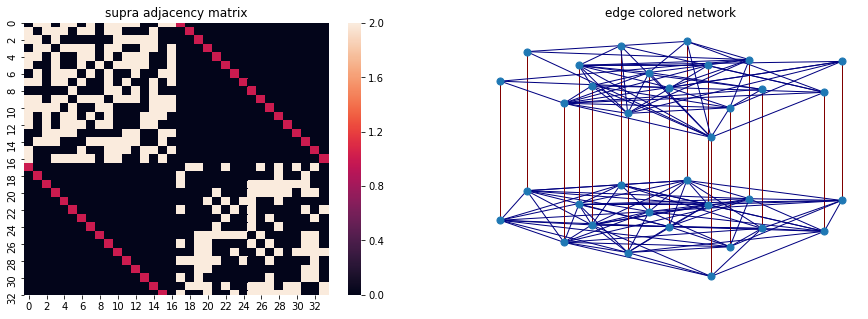

done writing file


In [9]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
                      layer_vertical_shift=0.3,
                      layer_horizontal_shift=0.0,
                      proj_angle=47)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
                 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
                 edge_cmap=plt.cm.jet_r)
plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

nLevels = 2
L2_classes = np.arange(nLevels)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLevels)}
x_dict = {key:float(pos[key][0]) for key in pos}
y_dict = {key:float(pos[key][1]) for key in pos}
L1_dict = {i:str(i) for i in np.arange(nNodes*nLevels)}
L2_dict = {i:1 for i in np.arange(nNodes)}
L2_dict.update({i:2 for i in (np.arange(nNodes)+ nNodes)})
L2_dict.update({i:3 for i in (np.arange(nNodes)+ 2*nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide9.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

In [11]:
## Ann consider getting 3d coordinates!



## Ex 2: 2 aspects, 5 layers


0 1
0 2
0 3
0 4
1 2
1 3
1 4
2 3
2 4
3 4


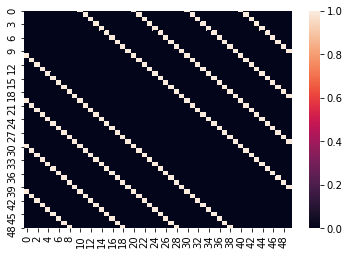

In [28]:
nNodes = 10
nLayers = 5

g1 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=218)
g2 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=132)
g3 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=192)
g4 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=19)
g5 = mx.generators.erdos_renyi_graph(nNodes,0.5,seed=102)

# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=[g1,g2,g3,g4,g5],
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


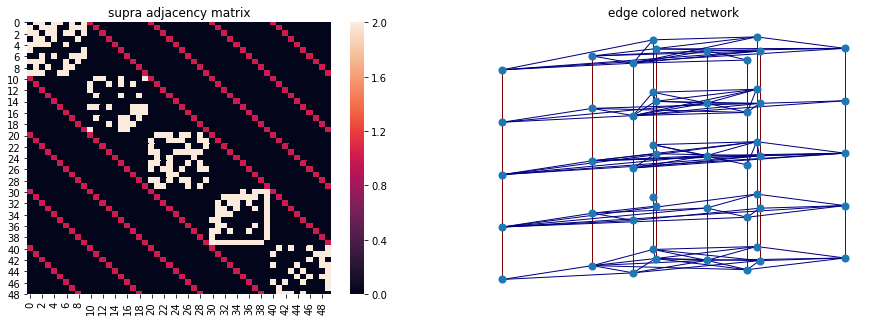

done writing file


In [29]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
                      layer_vertical_shift=0.3,
                      layer_horizontal_shift=0.0,
                      proj_angle=47)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
                 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
                 edge_cmap=plt.cm.jet_r)
plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

L2_classes = np.arange(nLayers)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
x_dict = {key:float(pos[key][0]) for key in pos}
y_dict = {key:float(pos[key][1]) for key in pos}
L1_dict = {i:str(i) for i in np.arange(nNodes*nLayers)}
L2_dict = {i:1 for i in np.arange(nNodes)}
L2_dict.update({i:2 for i in (np.arange(nNodes)+ nNodes)})
L2_dict.update({i:3 for i in (np.arange(nNodes)+ 2*nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide10.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

## Time series example

In [49]:
nNodes = 10
nLayers = 10

graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.identity(nNodes)   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


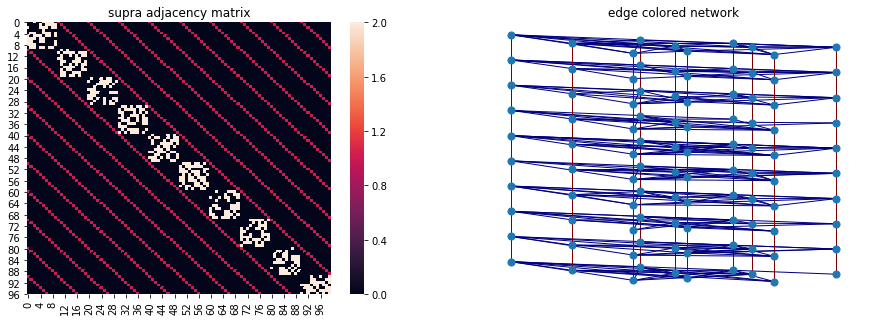

done writing file


In [50]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
                      layer_vertical_shift=2,
                      layer_horizontal_shift=0.0,
                      proj_angle=30)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
                 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
                 edge_cmap=plt.cm.jet_r)
plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

L2_classes = np.arange(nLayers)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
x_dict = {key:float(pos[key][0]) for key in pos}
y_dict = {key:float(pos[key][1]) for key in pos}
L1_dict = {i:str(i) for i in np.arange(nNodes*nLayers)}
L2_dict = {i:1 for i in np.arange(nNodes)}
L2_dict.update({i:2 for i in (np.arange(nNodes)+ nNodes)})
L2_dict.update({i:3 for i in (np.arange(nNodes)+ 2*nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide11.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

## Non-identity inter-layer connections

In [59]:
nNodes = 10
nLayers = 3

graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.random.choice([0,1],size=(nNodes,nNodes),replace=True,p=[0.9,0.1])   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


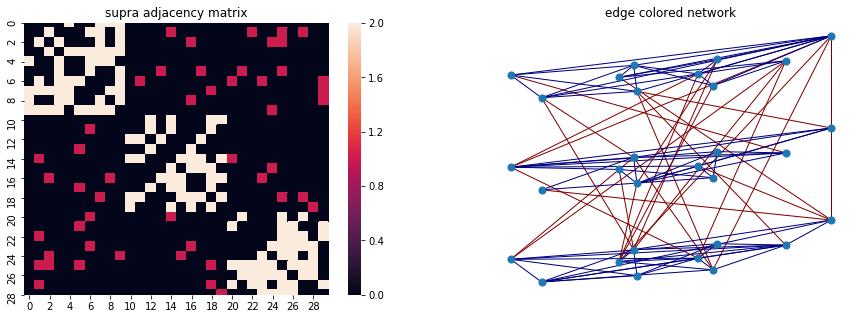

done writing file


In [63]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
                      layer_vertical_shift=2.5,
                      layer_horizontal_shift=0.0,
                      proj_angle=30)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
                 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
                 edge_cmap=plt.cm.jet_r)
plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

L2_classes = np.arange(nLayers)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
x_dict = {key:float(pos[key][0]) for key in pos}
y_dict = {key:float(pos[key][1]) for key in pos}
L1_dict = {i:str(i) for i in np.arange(nNodes*nLayers)}
L2_dict = {i:1 for i in np.arange(nNodes)}
L2_dict.update({i:2 for i in (np.arange(nNodes)+ nNodes)})
L2_dict.update({i:3 for i in (np.arange(nNodes)+ 2*nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide12.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")

## Case where nodes are not in every layer

In [64]:
nNodes = 10
nLayers = 4

graph_layers = [mx.generators.erdos_renyi_graph(nNodes,0.5,seed=np.random.randint(1,300)) for i in np.arange(nLayers)]


# Define adjacency between layers
adj_block = mx.lil_matrix(np.zeros((nNodes*nLayers,nNodes*nLayers)))

for i in np.arange(nLayers-1):
    for l in np.arange(i+1,nLayers):
        adj_block[i*nNodes:(i+1)*nNodes, (l)*nNodes:(l+1)*nNodes] = np.random.choice([0,1],size=(nNodes,nNodes),replace=True,p=[0.9,0.1])   # L_1*

adj_block += adj_block.T

# Create multilayer graph
mg = mx.MultilayerGraph(list_of_layers=graph_layers,
                        inter_adjacency_matrix=adj_block)

mg.set_edges_weights(intra_layer_edges_weight=2,
                     inter_layer_edges_weight=1)




In [ ]:
## Save to json and plot draft fig

fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
sns.heatmap(mx.adjacency_matrix(mg,weight='weight').todense())
ax1.set_title('supra adjacency matrix')

ax2 = fig.add_subplot(122)
ax2.axis('off')
ax2.set_title('edge colored network')
pos = mx.get_position(mg,mx.fruchterman_reingold_layout(g1),
                      layer_vertical_shift=2.5,
                      layer_horizontal_shift=0.0,
                      proj_angle=30)
mx.draw_networkx(mg,pos=pos,ax=ax2,node_size=50,with_labels=False,
                 edge_color=[mg[a][b]['weight'] for a,b in mg.edges()],
                 edge_cmap=plt.cm.jet_r)
plt.show()

## Define dictionaries and save to json

# From the sparse adj, make a networkx graph and add node attributes
G = nx.from_numpy_array(mx.adjacency_matrix(mg,weight='weight').todense())

## List of nodes not in each layer
nodes_to_remove = [4, 14, 12, 19, 21]

L2_classes = np.arange(nLayers)
## Each node will get attributes L1=node id, L2=slice number, x position, y position, and name/id

id_dict = {i:("id"+str(i)) for i in np.arange(nNodes*nLayers)}
x_dict = {key:float(pos[key][0]) for key in pos}
y_dict = {key:float(pos[key][1]) for key in pos}
L1_dict = {i:str(i) for i in np.arange(nNodes*nLayers)}
L2_dict = {i:1 for i in np.arange(nNodes)}
L2_dict.update({i:2 for i in (np.arange(nNodes)+ nNodes)})
L2_dict.update({i:3 for i in (np.arange(nNodes)+ 2*nNodes)})



# nx.set_node_attributes(G, pos, name="pos")
nx.set_node_attributes(G, id_dict, name = "name")
nx.set_node_attributes(G, x_dict, name = "x")
nx.set_node_attributes(G, y_dict, name = "y")
nx.set_node_attributes(G, L1_dict, name= "L1")
nx.set_node_attributes(G, L2_dict, name= "L2")

# ## Set edge attributes
# edge_dict = {}
# for edge in G.edges():
    
#     edge_dict[edge] = birth_times[max(edge[0],edge[1])]

# edge_dict
# nx.set_edge_attributes(G,edge_dict, name = "birth_time")

## Write to json file

G_json = json_graph.node_link_data(G)
with open('data/mx_slide13.json', 'w') as fp:
    json.dump(G_json, fp)

print("done writing file")